# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [156]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key
if weather_api_key == "YOUR KEY HERE!":
    import sys
    sys.path.append(r"C:\Users\nlund\Documents\GitHub\untracked_files")
    from api_keys_NRL import weather_api_key

print(weather_api_key)

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

b71963b5651be938ce326dc85e7b591d


In [157]:
# Define function for calculating linear regressions
def regress_line(x,y):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
    y_regress = x * slope + intercept
    line_text = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    print(f"The r-value is: {rvalue}")
    return y_regress, line_text

## Determine user's preferred data source

In [160]:
# Determine if user would like to load pre-populated weather data or
get_current_wx = input("Would you like to analyze current weather conditions (Y/N)?")

# If no, load provided data
if get_current_wx == "N":
    print("The user opted to load pre-populated weather data")
    input_file = "input_data\cities.csv"
    df_wx_data = pd.read_csv(input_file)
elif get_current_wx == "Y":
    print("The user opted to analyze current weather conditions")
else:
    print("The user chose an invalid option.")
    raise SystemExit("Stop executing notebook") 

The user opted to load pre-populated weather data


## Generate Cities List

In [161]:
if get_current_wx == "Y":
    # List for holding lat_lngs and cities
    lat_lngs = []
    cities = []

    # Create a set of random lat and lng combinations
    lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
    lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
    lat_lngs = zip(lats, lngs)

    # Identify nearest city for each lat, lng combination
    for lat_lng in lat_lngs:
        city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
        
        # If the city is unique, then add it to a our cities list
        if city not in cities:
            cities.append(city)

    # Print the city count to confirm sufficient count
    len(cities)

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [162]:
if get_current_wx == "Y":
    # Setup and call weather API

    # Save config information.
    url = "http://api.openweathermap.org/data/2.5/weather?"
    units = "imperial"

    # Build partial query URL
    query_url = f"{url}appid={weather_api_key}&units={units}&q="

    # set up lists to hold reponse info
    city_list = []
    lat_list = []
    lon_list = []
    max_temp_list = []
    humidity_list = []
    cloudiness_list = []
    wndspd_list = []
    country_list = []
    date_list = []
    call_counter = 1
    call_set = 1

    # Collect weather data using json api calls
    print('Beginning Data Retrieval')     
    print('-----------------------------')

    # Loop through the list of cities and perform a request for data on each and populate data lists
    for city in cities:
        response = requests.get(query_url + city).json()
        #print(json.dumps(response, indent=4, sort_keys=True))

        try:
            city_list.append(response['name'])
            lat_list.append(response['coord']['lon'])
            lon_list.append(response['coord']['lon'])
            max_temp_list.append(response['main']['temp_max'])
            humidity_list.append(response['main']['humidity'])
            cloudiness_list.append(response['clouds']['all'])
            wndspd_list.append(response['wind']['speed'])
            country_list.append(response['sys']['country'])
            date_list.append(response['dt'])

            print(f'Processing Record {call_counter} of Set {call_set} | {city}')

        except KeyError:
            print("City not found. Skipping...")

        if call_counter > 49:
            call_counter = 1
            call_set += 1
            time.sleep(10)    
        else:
            call_counter += 1

    print('-----------------------------')
    print('Data Retrieval Complete')      
    print('-----------------------------')

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [163]:
if get_current_wx == "Y":
    df_wx_data = pd.DataFrame({
        "City": city_list,
        "Lat": lat_list,
        "Lng": lon_list,
        "Max Temp": max_temp_list,
        "Humidity": humidity_list,
        "Cloudiness": cloudiness_list,
        "Wind Speed": wndspd_list,
        "Country": country_list,
        "Date": date_list})
df_wx_data.to_csv(output_data_file)
df_wx_data

,City_ID,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,0,ostrovnoy,2,RU,1558378754,72,68.05,39.51,37.50,7.16
1,1,mahebourg,75,MU,1558378503,74,-20.41,57.70,78.80,11.41
2,2,qaanaaq,25,GL,1558378755,73,77.48,-69.36,22.20,2.37
3,3,zhuhai,0,CN,1558378755,39,40.71,112.04,44.60,4.47
4,4,cape town,20,ZA,1558378755,76,-33.93,18.42,55.99,8.05
...,...,...,...,...,...,...,...,...,...,...
543,543,yabrud,0,SY,1558378840,32,33.97,36.66,80.60,8.05
544,544,paraiso,5,MX,1558378898,4,24.01,-104.61,84.20,16.11
545,545,veraval,0,FR,1558378898,62,49.65,0.71,61.00,8.05
546,546,novyy urgal,100,RU,1558378899,93,51.07,132.56,49.74,2.68


### Display summary statistics on the weather DataFrame

In [164]:
df_wx_data.describe()

,City_ID,Cloudiness,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
count,548.000000,548.000000,5.480000e+02,548.000000,548.000000,548.000000,548.000000,548.000000
mean,273.500000,49.405109,1.558379e+09,67.671533,19.665146,20.675529,64.970785,8.672682
std,158.338246,36.914201,7.820486e+01,23.697626,33.623560,90.307948,18.704318,5.865974
min,0.000000,0.000000,1.558378e+09,4.000000,-54.810000,-173.230000,4.920000,0.540000
25%,136.750000,13.750000,1.558379e+09,52.000000,-6.267500,-61.015000,53.970000,4.680000
50%,273.500000,46.500000,1.558379e+09,71.000000,21.390000,21.240000,64.990000,7.010000
75%,410.250000,81.000000,1.558379e+09,86.000000,47.887500,102.937500,80.600000,11.410000
max,547.000000,100.000000,1.558379e+09,290.000000,78.220000,179.320000,104.100000,46.080000


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

Nicole Lund: The dataset does not contain humidity > 100%. Skipping the removal of cities with this condition.

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [154]:
# Extract data collection date
pretty_date = []
for idx, row in df_wx_data.iterrows():
    data_time = time.localtime(row["Date"])
    pretty_date.append(f"{data_time.tm_mon}/{data_time.tm_mday}/{data_time.tm_year}")

collection_date = str(set(pretty_date)).strip("{'}")
print(f"Data collected on {collection_date}")

Data collected on 4/19/2021


## Latitude vs. Temperature Plot

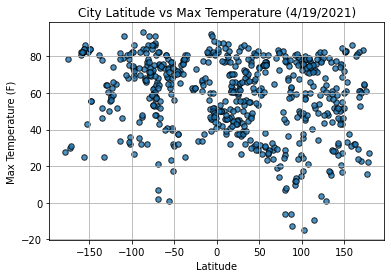

In [134]:
df_wx_data.plot(
    "Lat","Max Temp",
    title=f"City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.savefig("output_data/lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Max temperature plot shows the latitude for each city vs the maximum temperature seen that day.

## Latitude vs. Humidity Plot

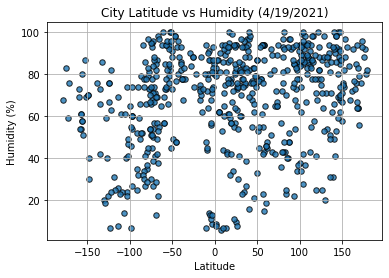

In [135]:
df_wx_data.plot(
    "Lat","Humidity",
    title=f"City Latitude vs Humidity ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.savefig("output_data/lat_humidity.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Humidity plot shows the latitude for each city vs the current humidity.

## Latitude vs. Cloudiness Plot

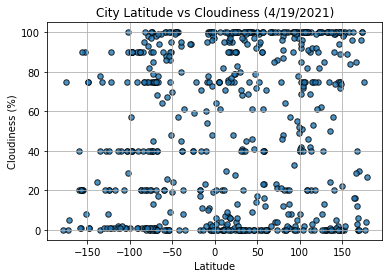

In [136]:
df_wx_data.plot(
    "Lat","Cloudiness",
    title=f"City Latitude vs Cloudiness ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.savefig("output_data/lat_cloudiness.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Cloudiness plot shows the latitude for each city vs the percentage of the sky currently covered by clouds.

## Latitude vs. Wind Speed Plot

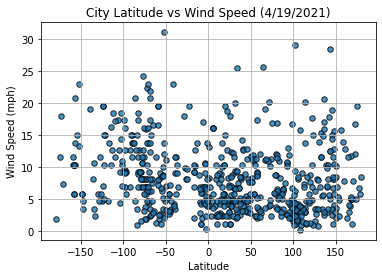

In [137]:
df_wx_data.plot(
    "Lat","Wind Speed",
    title=f"City Latitude vs Wind Speed ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.savefig("output_data/lat_wndspd.png",facecolor='w')
plt.show()

Nicole Lund: The Latitude vs Wind Speed plot shows the latitude for each city vs the current wind speed.

## Linear Regression

### Latitude vs. Temperature Plots with linear regression

* Northern hemisphere
* Southern hemisphere

In [138]:
# Collect data by northern and southern hemispheres
df_wx_data_N_hemi = df_wx_data.loc[df_wx_data["Lat"]>=0]
df_wx_data_S_hemi = df_wx_data.loc[df_wx_data["Lat"]<0]
df_wx_data_S_hemi

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Chapais,-74.8492,-74.8492,53.60,30,90,6.91,CA,1618871623
3,Tuktoyaktuk,-133.0374,-133.0374,24.80,86,75,2.30,CA,1618871421
5,Bonavista,-53.1147,-53.1147,39.99,100,100,3.44,CA,1618871625
10,Tasiilaq,-37.6368,-37.6368,24.80,68,8,11.50,GL,1618871627
13,Qaanaaq,-69.3632,-69.3632,2.17,82,98,6.26,GL,1618871628
...,...,...,...,...,...,...,...,...,...
588,San Jerónimo,-75.2829,-75.2829,53.42,74,97,3.04,PE,1618871941
591,La Romana,-68.9728,-68.9728,82.40,69,20,13.80,DO,1618871942
592,Eureka,-124.1637,-124.1637,55.99,67,40,7.00,US,1618871713
593,Newport,-2.9984,-2.9984,46.99,81,73,2.30,GB,1618871786


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.08651706286516948


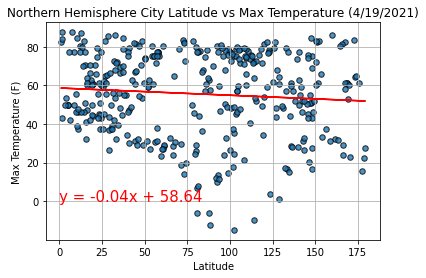

In [144]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_N_hemi["Lat"],df_wx_data_N_hemi["Max Temp"])

# Plot the data
df_wx_data_N_hemi.plot(
    "Lat","Max Temp",
    title=f"Northern Hemisphere City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_N_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(0,0),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.savefig("output_data/north_lat_temp.png",facecolor='w')
plt.show()

Nicole Lund: The linear regression is modeling the trend of Max Temperature as Latitude increases. There is a very slight negative slope in the linear regression that indicates it gets colder the further north one travels.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.046830234907684745


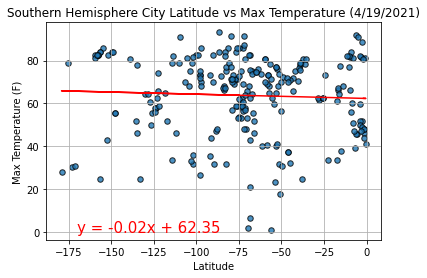

In [146]:
# Calculate Linear Regression
y_regress, line_text = regress_line(df_wx_data_S_hemi["Lat"],df_wx_data_S_hemi["Max Temp"])

# Plot the data
df_wx_data_S_hemi.plot(
    "Lat","Max Temp",
    title=f"Southern Hemisphere City Latitude vs Max Temperature ({collection_date})",
    kind='scatter',
    grid=True,
    style="o",
    facecolors="blue",
    edgecolors="black",
    alpha = 0.8,
    s=30
    )

plt.plot(df_wx_data_S_hemi["Lat"],y_regress,"r-")
plt.annotate(line_text,(-170,0),fontsize=15,color="red")

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.savefig("output_data/south_lat_temp.png",facecolor='w')
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression